# Classification
**Objective**: Predict if an earthquake causes a tsunami

In [82]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, learning_curve, LearningCurveDisplay
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42)

## Data Loading

In [83]:
df = pd.read_csv('../data/earthquake_data_tsunami.csv')

## Splitting Data

In [ ]:
X = df.drop('tsunami', axis=1) # Features
y = df['tsunami'] # Target variable

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y, random_state=42)
X_train.shape, X_test.shape

((547, 12), (235, 12))

## Preprocessing

In [85]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## LazyPredict Benchmark

In [86]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train_scaled, X_test_scaled, y_train, y_test)
print(f"Best 2 models")
print(models.head(2))

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 213, number of negative: 334
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 944
[LightGBM] [Info] Number of data points in the train set: 547, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,389397 -> initscore=-0,449849
[LightGBM] [Info] Start training from score -0,449849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

## Hyperparameters Tuning (Top 2 model + SVC, KNN, BaggingClassifier)

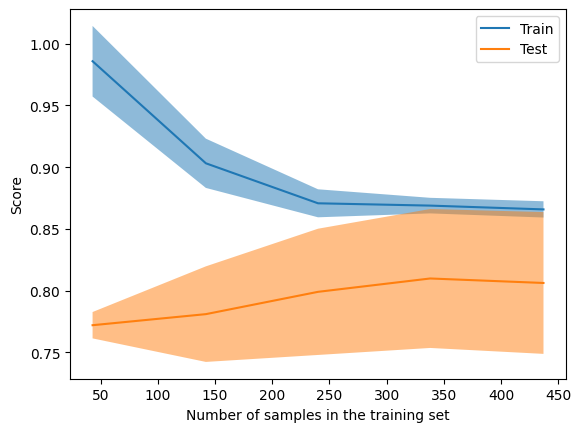

Best params {'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Best score 0.8243811285846439


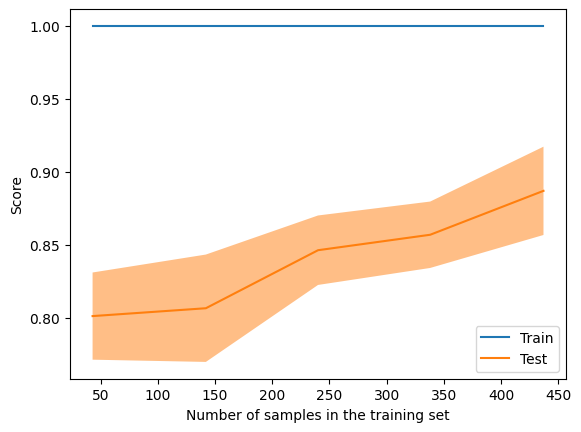

Best params {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 50}
Best score 0.8891887192879169


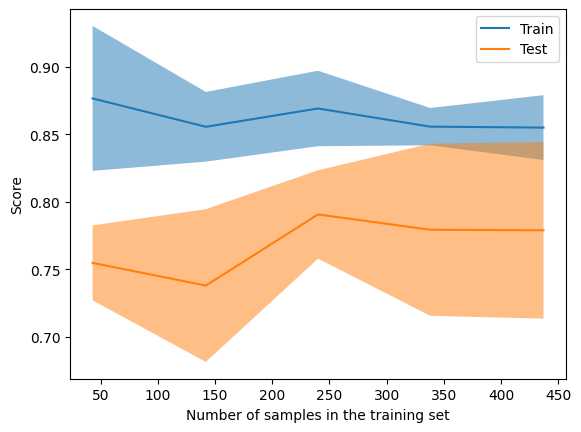

Best params {'n_neighbors': 8, 'weights': 'distance'}
Best score 0.803729481910825


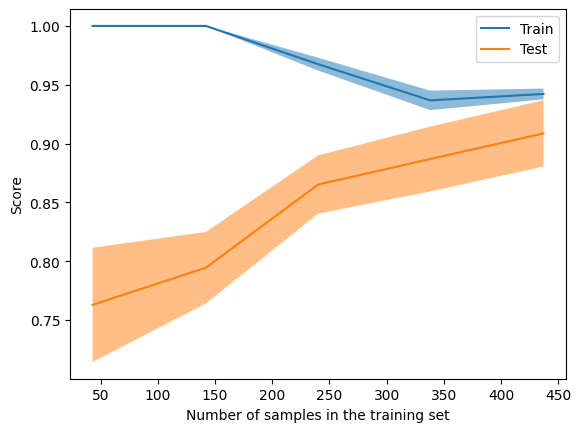

Best params {'learning_rate': 1.0, 'n_estimators': 25}
Best score 0.9083065422219112


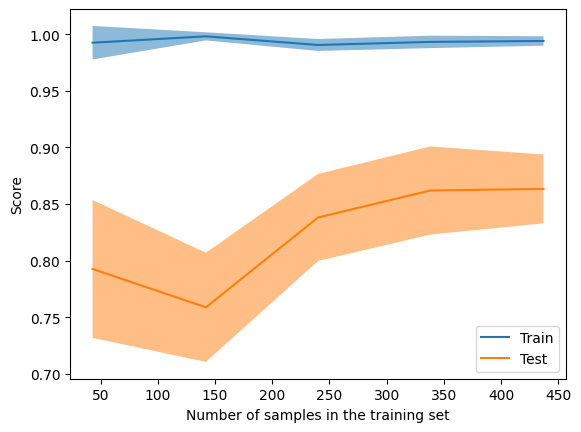

Best params {'max_samples': 0.5, 'n_estimators': 20}
Best score 0.9011111111111111
{'SVC': {'best_params': {'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}, 'cv_f1': np.float64(0.8243811285846439), 'test_f1': 0.8195121951219512, 'model': SVC(degree=2, kernel='linear', random_state=42)}, 'RandomForestClassifier': {'best_params': {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 50}, 'cv_f1': np.float64(0.8891887192879169), 'test_f1': 0.8888888888888888, 'model': RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=50,
                       random_state=42)}, 'KNeighborsClassifier': {'best_params': {'n_neighbors': 8, 'weights': 'distance'}, 'cv_f1': np.float64(0.803729481910825), 'test_f1': 0.8021390374331551, 'model': KNeighborsClassifier(n_neighbors=8, weights='distance')}, 'AdaBoostClassifier': {'best_params': {'learning_rate': 1.0, 'n_estimators': 25}, 'cv_f1': np.float64(0.9083065422219112), 'test_f1': 0.9025641025641026, 'model': AdaBoostClassifier(n_

In [87]:
models = {
    'SVC': SVC(random_state=42),
    'RandomForestClassifier': RandomForestClassifier(class_weight='balanced', random_state=42),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(random_state=42),
    'BaggingClassifier': BaggingClassifier(random_state=42),
}

params_grid = {
    'SVC': {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': [2,3,4],
        'gamma': ['scale', 'auto']
    },
    'RandomForestClassifier': {
        'n_estimators': [50,100,200],
        'max_depth': [None, 10, 20],
        'criterion': ['gini', 'entropy']
    },
    'KNeighborsClassifier': {
        'n_neighbors': [2,5,8],
        'weights': ['uniform', 'distance']
    },
    'AdaBoostClassifier': {
        'n_estimators': [25,50,100],
        'learning_rate': [0.5,1.0,2.0]
    },
    'BaggingClassifier': {
        'n_estimators': [5,10,20],
        'max_samples': [0.5, 1.0, 1.5] 
    }
}

training_results = {}
for model_key, model in models.items():

    grid = GridSearchCV(
        estimator=model,
        param_grid=params_grid[model_key],
        scoring='f1',
        cv=5,
        n_jobs=-1,
    )
    
    grid.fit(X_train_scaled, y_train)

    train_sizes, train_scores, test_scores = learning_curve(model, X_train_scaled, y_train, scoring='f1', cv=5, n_jobs=-1)
    display = LearningCurveDisplay(
        train_sizes=train_sizes,
        train_scores=train_scores,
        test_scores=test_scores,
        score_name="Score"
    )
    display.plot()
    plt.show()
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    
    f1 = f1_score(y_test, y_pred)
    
    training_results[model_key] = {
        'best_params': grid.best_params_,
        'cv_f1': grid.best_score_,
        'test_f1': f1,
        'model': best_model
    }
    
    print(f"Best params {grid.best_params_}")
    print(f"Best score {grid.best_score_}")
    
print(training_results)

## Model Comparison


Model Comparison:
                    Model  CV F1 Score  Test F1 Score
4       BaggingClassifier         0.90           0.91
3      AdaBoostClassifier         0.91           0.90
1  RandomForestClassifier         0.89           0.89
0                     SVC         0.82           0.82
2    KNeighborsClassifier         0.80           0.80


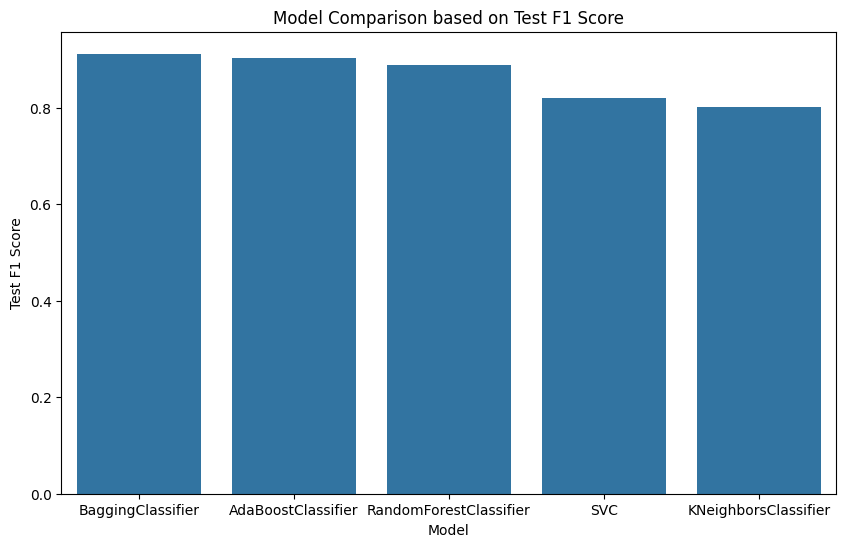

In [88]:
comparison = pd.DataFrame([
    {
        'Model': model,
        'CV F1 Score': results['cv_f1'],
        'Test F1 Score': results['test_f1']
    }
    for model, results in training_results.items()
])

comparison = comparison.sort_values(by='Test F1 Score', ascending=False)
print("\nModel Comparison:")
print(comparison)


plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='Test F1 Score', data=comparison)
plt.title('Model Comparison based on Test F1 Score')
plt.ylabel('Test F1 Score')
plt.yscale('linear')
plt.show()

## Best Model Evaluation

              precision    recall  f1-score   support

           0       0.98      0.90      0.94       144
           1       0.86      0.97      0.91        91

    accuracy                           0.93       235
   macro avg       0.92      0.93      0.93       235
weighted avg       0.93      0.93      0.93       235



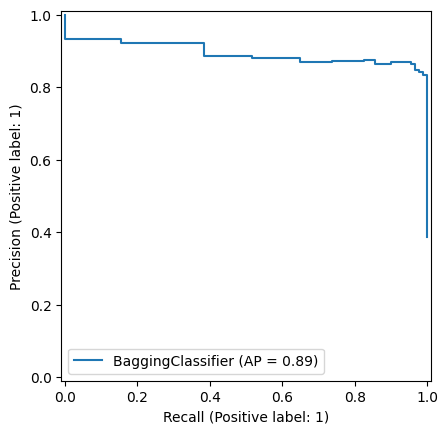

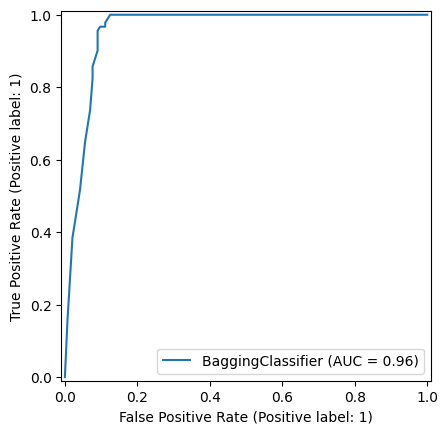

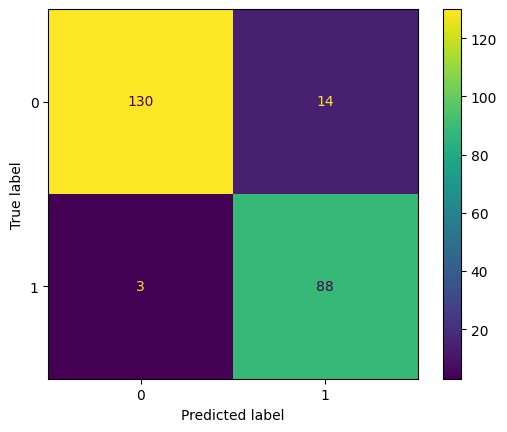

In [89]:
best_model_name = comparison.iloc[0]['Model']
best_model = training_results[best_model_name]["model"]

y_pred_best = best_model.predict(X_test_scaled)

print(classification_report(y_test, y_pred_best))

PrecisionRecallDisplay.from_estimator(best_model, X_test_scaled, y_test)
plt.show()

RocCurveDisplay.from_estimator(best_model, X_test_scaled, y_test)
plt.show()

ConfusionMatrixDisplay.from_estimator(best_model, X_test_scaled, y_test)
plt.show()
